In [1]:
import numpy as np
import random
import os, sys, glob, pickle
import pdb, time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

import sklearn
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve
from collections import Counter

import torch_geometric
import torch_geometric.transforms as T
import torch_geometric.nn as geo_nn
from torch_geometric.data import Data, Dataset, DataLoader

from layers import *
import math
from itertools import chain
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"]="0"
best_auc_fold = 0

In [2]:
class GraphDataset(Dataset):
    def __init__(self, pickle_files_dir, file_list):
        self.pickle_files_dir=pickle_files_dir
        self.file_list = file_list
        

    def __getitem__(self, index):
        file_name = self.file_list[index]
        
        # if self.augment:
            # TODO
            
        # print('\n\n', file_name, '\n\n')
        with open(file_name,'rb') as file:
            data = pickle.load(file)

        vertex = data[0]

        edge = data[1]
#         edge, _ =  torch_geometric.utils.add_remaining_self_loops(edge)
        
        l = torch.tensor(data[2])

        slide_idx = torch.tensor(data[3], dtype=torch.int)
        
        data_ =  Data(x=vertex, edge_index=edge, y=l)
        data_.slide_idx = slide_idx

        return data_

    def __len__(self):
        return len(self.file_list)


In [3]:
# ---------------------------- NETWORK --------------------------


class Net_geo_mil(nn.Module):
    def __init__(self):
        super(Net_geo_mil, self).__init__()

        # Conv Layer candidates
        # AGNNConv
        # ARMAConv
        # DynamicEdgeConv
        # GATConv
        # GCNConv - GINConv better?
        # SAGEConv
        # SGConv

        # Norm Later candidates
        # BatchNorm - batch normalization over a batch of node features
        # InstanceNorm - instance normalization over each individual example in a batch of node features

        # Pooling
        # EdgePooling - needs an edge score method
        # SAGPooling - needs a GNN for calculating projection scores
        # TopKPooling - better than SAGPool
        # nearest
        # radius

        # Global Pool to get graph level output

        # TODO
        # First input layer - normalise size ... how?
        # Node feature conv - reduce number from 438 to more managable
        # Edge conv? Edge features? Edge scores from incident nodes? - batchwise too

        # self.GCNConv1 = geo_nn.GCNConv(438,512, add_self_loops = False, normalize = True, improved = True, cached = False, bias = True)
        # self.bn1 = nn.BatchNorm1d(54)
#         self.GINConv1 = geo_nn.GINConv(nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 256)))
#         self.GINConv2 = geo_nn.GINConv(nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128)))
#         self.GCNConv1 = geo_nn.GCNConv(512,256, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
#         self.GCNConv2 = geo_nn.GCNConv(256,128, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
        # self.GCNConv5 = geo_nn.GCNConv(128,128, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
#         self.gc1 = geo_nn.GraphConv(512, 256)
#         self.gc2 = geo_nn.GraphConv(256, 128)
        self.gcn1 = GraphCNNLayer_geo(512,256,1)
        self.gcn2 = GraphCNNLayer_geo(256,128,1)

        # self.bn1 = nn.BatchNorm1d(128)

        self.SAGPool1 = geo_nn.SAGPooling(128, ratio=0.5) # 586+438=1024
#         self.TopKPool1 = geo_nn.TopKPooling(128, ratio=0.5)
        # self.EdgePool1 = geo_nn.EdgePooling(128) # ratio is always 0.5

        # self.GCNConv2 = geo_nn.GCNConv(512, 256, add_self_loops = False, normalize = True, improved = True, cached = False, bias = True)
        
#         self.GINConv3 = geo_nn.GINConv(nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 128)))
#         self.GINConv4 = geo_nn.GINConv(nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 128)))
#         self.GCNConv3 = geo_nn.GCNConv(128,128, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
#         self.GCNConv4 = geo_nn.GCNConv(128,128, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
        # self.GCNConv6 = geo_nn.GCNConv(256,256, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
#         self.gc3 = geo_nn.GraphConv(128, 128)
#         self.gc4 = geo_nn.GraphConv(128, 128)
        self.gcn3 = GraphCNNLayer_geo(128,128,1)
        self.gcn4 = GraphCNNLayer_geo(128,128,1)

        # self.bn2 = nn.BatchNorm1d(256)

        # self.SAGPool2 = geo_nn.SAGPooling(512, ratio=0.5) # 1024+256=1280
        # self.TopKPool2 = geo_nn.TopKPooling(256, ratio=0.5)

        # self.GCNConv3 = geo_nn.GCNConv(256, 256, add_self_loops = False, normalize = True, improved = True, cached = False, bias = True)
        
        # self.GINConv5 = geo_nn.GINConv(nn.Sequential(nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 256)))
        # self.GINConv6 = geo_nn.GINConv(nn.Sequential(nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 256)))
        # self.GCNConv5 = geo_nn.GCNConv(256,256, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
        # self.GCNConv6 = geo_nn.GCNConv(256,256, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)

        # self.bn3 = nn.BatchNorm1d(256)

        self.SAGPool3 = geo_nn.SAGPooling(128, ratio=0.5)
#         self.TopKPool3 = geo_nn.TopKPooling(128, ratio=0.5)
        # self.EdgePool3 = geo_nn.EdgePooling(256) # ratio is always 0.5

#         self.GINConv7 = geo_nn.GINConv(nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 128)))
#         self.GCNConv7 = geo_nn.GCNConv(128,128, add_self_loops = True, normalize = True, improved = True, cached = False, bias = True)
#         self.gc7 = geo_nn.GraphConv(128, 128)
        self.gcn7 = GraphCNNLayer_geo(128,128,1)
        
        
        self.attention = nn.Sequential(
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

        self.post_gcn = nn.Sequential(
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(), 
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), 
            nn.Linear(64,2)
            )



    def forward(self, batch, x, edge_index, slide_idx, y_target):
        # TODO
        edge_attr = None
        # x = self.bn1(x)
#         x = self.GINConv2(self.GINConv1(x, edge_index), edge_index) # x of shape [num_nodes, 512] now
        # x = self.GCNConv5(self.GCNConv2(self.GCNConv1(x, edge_index), edge_index), edge_index)
#         x = self.GCNConv2(self.GCNConv1(x, edge_index), edge_index)
#         x = self.gc2(self.gc1(x, edge_index), edge_index)
        x = self.gcn1(x, edge_index, edge_attr, batch)
        x = self.gcn2(x, edge_index, edge_attr, batch)
        # x = torch.cat((x, self.GINConv2(self.GINConv1(x, edge_index), edge_index)), dim=1) # x of shape [num_nodes, 438+586=1024] now

        # x = self.bn1(x)

        x, edge_index, edge_attr, batch, _,_ = self.SAGPool1(x, edge_index, batch=batch)
#         x, edge_index, _, batch, _,_ = self.TopKPool1(x, edge_index, batch=batch)
        # x, edge_index, batch, _ = self.EdgePool1(x, edge_index, batch)
        

#         x = self.GINConv4(self.GINConv3(x, edge_index), edge_index) # x of shape [num_nodes, 512] now 
        # x = self.GCNConv6(self.GCNConv4(self.GCNConv3(x, edge_index), edge_index), edge_index)
#         x = self.GCNConv4(self.GCNConv3(x, edge_index), edge_index)
#         x = self.gc4(self.gc3(x, edge_index), edge_index)
        x = self.gcn3(x, edge_index, edge_attr, batch)
        x = self.gcn4(x, edge_index, edge_attr, batch)
        # x = torch.cat((x, self.GINConv4(self.GINConv3(x, edge_index), edge_index)), dim=1) # x of shape [num_nodes, 1024] now 
 
        # x = self.bn2(x)

        # x, edge_index, edge_attr, batch, _,_ = self.SAGPool2(x, edge_index, edge_attr=edge_attr, batch=batch)
        # x, edge_index, _, batch, _,_ = self.TopKPool2(x, edge_index, batch=batch)

        # slide_idx = slide_idx[perm]


        # x = self.GINConv6(self.GINConv5(x, edge_index), edge_index) # x of shape [num_nodes, 512] now 
        # x = torch.cat((x, self.GINConv6(self.GINConv5(x, edge_index), edge_index)), dim=1) # x of shape [num_nodes, 1024+512] now 
        # x = self.GINConv6(self.GINConv5(x, edge_index), edge_index) # x of shape [num_nodes, 512] now
        # x = self.GCNConv6(self.GCNConv5(x, edge_index), edge_index)

        
        # x = self.bn3(x)
        
        x, edge_index, _, batch, _,_ = self.SAGPool3(x, edge_index, batch=batch)
#         x, edge_index, _, batch, _,_ = self.TopKPool3(x, edge_index, batch=batch)
        # x, edge_index, batch, _ = self.EdgePool3(x, edge_index, batch)

#         x = self.GINConv7(x, edge_index) # x of shape [num_nodes, 512]
#         x = self.GCNConv7(x, edge_index)
#         x = self.gc7(x, edge_index)
        x = self.gcn7(x, edge_index, edge_attr, batch)
        # x = torch.cat((x, self.GINConv7(x, edge_index)), dim=1) # x of shape [num_nodes, 2048]

        x = geo_nn.global_mean_pool(x, batch) # x of shape [1, 128] now - for each graph in batch
        # x = geo_nn.global_max_pool(x, batch) # x of shape [1, 128] now - for each graph in batch
        
        slide_idx, idx = slide_idx.sort()
        x = x[idx, :] # 
        y_target = y_target[idx]
        
        slide_idx, counts = slide_idx.unique(return_counts=True)
        
        len_for = slide_idx.size()[0]
        
        corr_idx = 0     
        A = torch.zeros([len_for, x.size()[0]], device=x.device, dtype=x.dtype)
        
        for jdx in range(len_for):
            y_target[jdx] = y_target[corr_idx]
            
#             for Attn MIL
            aa = self.attention(x[corr_idx: corr_idx+counts[jdx], :]) # bagsizex1
            aa = torch.transpose(aa, 1, 0)  # 1 x bag

#             for MIL
#             aa = torch.ones([1, counts[jdx]])
    
            aa = F.softmax(aa, dim=1)  # softmax over N, 1 x bag
            A[jdx, corr_idx:corr_idx+counts[jdx]] = aa

            corr_idx += counts[jdx]
        
#         pdb.set_trace()
        x = torch.mm(A, x)  # number of bags x 128

        x = self.post_gcn(x)
        
        y_target = y_target[:len_for]

        return x, y_target




In [4]:
def calc_acc_and_auc(model, device, data_loader, loss_ce, plot = False):

    y_score = []
    y_true  = []
    y_pred = []
    m = nn.Softmax(dim = 1)
    correct_preds = 0

    for batch_idx, data_ in enumerate(data_loader):
        with torch.no_grad():
            batch = data_['batch'].to(device)
            edge_index = data_['edge_index'].to(device)
            slide_idx = data_['slide_idx'].to(device)
            x_data = data_['x'].to(device)
            y_target = data_['y'].to(device)

            model.eval()

            output, y_target = model(batch, x_data, edge_index, slide_idx, y_target) 
            
            preds = output.max(1, keepdim=True)[1]
            correct_preds += preds.eq(y_target.view_as(preds)).sum().item()
            
            y_score.append(np.array(m(output).cpu()[:,1]).tolist())
            y_true.append(np.array(y_target.cpu()).tolist())
            y_pred.append(np.array(m(output).max(1,keepdim=True)[1].cpu()).tolist())

            del batch
            del slide_idx
            del edge_index
            del x_data       
            del y_target 

            torch.cuda.empty_cache()

    try:
        y_true = list(chain(*y_true))
        y_score = list(chain(*y_score))
        y_pred = list(chain(*y_pred))
        auc = roc_auc_score(y_true,y_score) # TODO - check this
        # pdb.set_trace()
    except ValueError as e:
        print("auc has error")
        print(e)
        pdb.set_trace()
        auc = 0

    if plot:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        print('showing plot')
        plt.savefig('auc_roc_curve_'+str(data_loader)+'.png')
    acc = 100.*correct_preds/len(data_loader.dataset)
    return acc, auc

In [5]:
def train(args, model, device, loss_ce, train_loader, optimizer, epoch, test_loader):
    global best_auc_fold

    running_loss = 0.
    correct_preds = 0
    elements = 0

    for batch_idx, data_ in enumerate(train_loader):

        batch = data_['batch'].to(device)
        slide_idx = data_['slide_idx'].to(device)
        edge_index = data_['edge_index'].to(device)
        x_data = data_['x'].to(device)
        y_target = data_['y'].to(device)

        optimizer.zero_grad()

        # for idx_iter in range(args['num_iter']):
        model.train()

        output, y_target = model(batch, x_data, edge_index, slide_idx, y_target) 
        
        loss = loss_ce(output, y_target) 
        preds = output.max(1, keepdim=True)[1]
        elements += len(y_target)
        train_batch_corr = preds.eq(y_target.view_as(preds)).sum().item()
        train_batch_accuracy = (100*train_batch_corr)/len(y_target)
        correct_preds += train_batch_corr
        # pdb.set_trace()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        curr_loss = loss.item()
        running_loss += loss.item()*data_.num_graphs
        idx = batch_idx + (epoch-1)*math.ceil(len(train_loader))
#         writer.add_scalar('Train Loss', curr_loss, idx)  
#         writer.add_scalar('Train Batch Accuracy', train_batch_accuracy, idx)
        # if epoch == 10:
        #     pdb.set_trace()

        del batch
        del slide_idx
        del edge_index
        del x_data       
        del y_target 

        torch.cuda.empty_cache()

        if batch_idx % args['log_interval'] == 0 :
            acc_test, auc_test = calc_acc_and_auc(model, device, test_loader, loss_ce)

#             writer.add_scalar('Test Acc', acc_test, idx)
#             writer.add_scalar('AUC', auc_test, idx)

            print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.6f} \tAcc Train: {:.2f}% \tAcc test {:.2f}\tTest AUC: {:.3f}'.format(
                epoch, 100. * (batch_idx+1) / len(train_loader), curr_loss, 100.*correct_preds/elements,acc_test, auc_test))

            if auc_test>best_auc_fold and auc_test > 0.6:
                best_auc_fold = auc_test
#                 torch.save({
#                     'epoch': epoch + 1,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'auc' : auc_test,
#                     }, args['resume'][fold]+'_testauc_'+str(auc_test)+'_new.pth.tar')
                print('Saving best AUC: '+ str(auc_test))

    running_loss /= len(train_loader.dataset)
    print("Loss for epoch {} is: {:.6f} \tAccuracy for Epoch is {:.2f}".format(epoch, running_loss, 100.*correct_preds/elements))
#     writer.add_scalar('Train loss epoch', running_loss, epoch)

    return 


In [6]:
# ------------------- Create args ----------------------
global best_auc_fold
args = {}
args['batch_size'] = 200
args['test_batch_size'] = 200
args['no_cuda']=False
args['seed']=7
args['lr']=0.01
# args['momentum']=0.5
args['log_interval']=5
args['epochs']=15 # epochs per fold
args['num_iter']=1
args['start_epoch']=1
use_cuda = not args['no_cuda'] and torch.cuda.is_available()
torch.manual_seed(args['seed'])
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
# args['resume']=['checkpoints_TCGA/discard_TCGA_split2_initGCN5_noVGG_topK_.pth.tar' for fold in range(no_of_folds)]
# args['resume']=['checkpoints_TCGA/TCGA_run_54params_topK_initBN_folds_0.pth.tar_auc_0.7935537982266956_new.pth.tar']
acccuracies = []
max_accuracies = []

best_auc_fold = 0


# ----------------------------Create dataset ----------------------------------------------

train_file_list = pickle.load(open('test_train_split/train_file_seed_2.pickle','rb')) 
test_file_list = pickle.load(open('test_train_split/test_file_seed_2.pickle','rb'))

dataset_train = GraphDataset('data_graphs/', train_file_list)
dataset_test = GraphDataset('data_graphs/', test_file_list)

train_loader = DataLoader(dataset = dataset_train, batch_size = args['batch_size'], shuffle = True, **kwargs) # no collate req; drop_last?; kwarg? 
test_loader = DataLoader(dataset = dataset_test, batch_size = args['test_batch_size'], shuffle = True, **kwargs)


# ---------------------Create model and other primitives --------------------------------------

model = Net_geo_mil().float() # model at float32 precision
# batchnorm needs accumulators to be big else they'll overflow
# so set those to float32
for layer in model.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float32()
model = model.to(device)
print(model)
# pdb.set_trace()
# model = nn.DataParallel(model, device_ids=[1, 2]).to(device)

# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'],weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

#optimizer = optim.Adam(model.parameters(), lr=args['lr'],weight_decay=0)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.707 , last_epoch=-1)

# keep loss as float32 else it will overflow
loss_ce = nn.CrossEntropyLoss(weight = torch.tensor([0.972, 1.028],  dtype = torch.float32, device = device), reduction = 'sum') # Train on TCGA


Net_geo_mil(
  (gcn1): GraphCNNLayer_geo(
    (lin_A): Linear(in_features=512, out_features=256, bias=True)
    (lin_I): Linear(in_features=512, out_features=256, bias=False)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (gcn2): GraphCNNLayer_geo(
    (lin_A): Linear(in_features=256, out_features=128, bias=True)
    (lin_I): Linear(in_features=256, out_features=128, bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (SAGPool1): SAGPooling(GraphConv, 128, ratio=0.5, multiplier=1)
  (gcn3): GraphCNNLayer_geo(
    (lin_A): Linear(in_features=128, out_features=128, bias=True)
    (lin_I): Linear(in_features=128, out_features=128, bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (gcn4): GraphCNNLayer_geo(
    (lin_A): Linear(in_features=128, out_features=128, bias=True

In [7]:
# if args['resume'] is not None:
#     if os.path.isfile(args['resume'][fold]):
#         print("=> loading checkpoint '{}'".format(args['resume'][fold]))
#         checkpoint = torch.load(args['resume'][fold])
#         args['start_epoch'] = checkpoint['epoch']
#         # best_prec1 = checkpoint['best_prec1']
#         # print("best_prec is ", best_prec1)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         # scheduler.load_state_dict(checkpoint['scheduler'])
#         acc, auc = calc_acc_and_auc(model, device, test_loader, loss_ce, plot=True)
#         print('acc test is {:.6f}, auc on test is {:.2f}'.format(acc, auc))
#         acc, auc = calc_acc_and_auc(model, device, test_loader_JH, loss_ce, plot=True)
#         print('acc JH is {:.6f}, auc on JH is {:.2f}'.format(acc, auc))
#         sys.exit(0)
#     else:
#         print("=> no checkpoint found at '{}'".format(args['resume'][fold]))
#         # sys.exit(0)

for epoch in range(args['start_epoch'], args['epochs'] + 1):
    
    train(args, model, device, loss_ce, train_loader, optimizer, epoch, test_loader)
    scheduler.step()

    # torch.save({
    #     'epoch': epoch + 1,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'scheduler': scheduler.state_dict(),
    #     }, args['resume'][fold])

del model
torch.cuda.empty_cache()

print("Best auc: ", best_auc_fold)

for k, v in args.items():
    print(k, v)

Train Epoch: 1 [(4%)]	Loss: 62.897442 	Acc Train: 50.00% 	Acc test 5.11	Test AUC: 0.293
Train Epoch: 1 [(21%)]	Loss: 60.126022 	Acc Train: 49.80% 	Acc test 6.07	Test AUC: 0.643
Saving best AUC: 0.6431440045897877
Train Epoch: 1 [(39%)]	Loss: 56.079708 	Acc Train: 50.61% 	Acc test 6.22	Test AUC: 0.407
Train Epoch: 1 [(57%)]	Loss: 52.788177 	Acc Train: 51.88% 	Acc test 7.62	Test AUC: 0.629
Train Epoch: 1 [(75%)]	Loss: 56.300102 	Acc Train: 52.64% 	Acc test 9.40	Test AUC: 0.787
Saving best AUC: 0.78656462585034
Train Epoch: 1 [(93%)]	Loss: 54.258621 	Acc Train: 53.33% 	Acc test 9.03	Test AUC: 0.766
Loss for epoch 1 is: 56.905543 	Accuracy for Epoch is 53.47
Train Epoch: 2 [(4%)]	Loss: 55.033497 	Acc Train: 61.25% 	Acc test 8.51	Test AUC: 0.750
Train Epoch: 2 [(21%)]	Loss: 54.076111 	Acc Train: 55.19% 	Acc test 9.03	Test AUC: 0.737
Train Epoch: 2 [(39%)]	Loss: 54.834030 	Acc Train: 56.49% 	Acc test 6.14	Test AUC: 0.697
Train Epoch: 2 [(57%)]	Loss: 54.351158 	Acc Train: 57.37% 	Acc test 6.4

Train Epoch: 14 [(93%)]	Loss: 55.760880 	Acc Train: 63.42% 	Acc test 8.36	Test AUC: 0.746
Loss for epoch 14 is: 51.901042 	Accuracy for Epoch is 63.31
Train Epoch: 15 [(4%)]	Loss: 55.101959 	Acc Train: 65.91% 	Acc test 8.44	Test AUC: 0.735
Train Epoch: 15 [(21%)]	Loss: 47.191921 	Acc Train: 63.07% 	Acc test 8.59	Test AUC: 0.752
Train Epoch: 15 [(39%)]	Loss: 53.433651 	Acc Train: 62.02% 	Acc test 8.29	Test AUC: 0.732
Train Epoch: 15 [(57%)]	Loss: 56.841957 	Acc Train: 62.29% 	Acc test 8.51	Test AUC: 0.750
Train Epoch: 15 [(75%)]	Loss: 55.835194 	Acc Train: 61.94% 	Acc test 8.59	Test AUC: 0.742
Train Epoch: 15 [(93%)]	Loss: 56.474827 	Acc Train: 61.92% 	Acc test 8.07	Test AUC: 0.734
Loss for epoch 15 is: 52.645284 	Accuracy for Epoch is 61.62
Best auc:  0.78656462585034
batch_size 200
test_batch_size 200
no_cuda False
seed 7
lr 0.01
log_interval 5
epochs 15
num_iter 1
start_epoch 1


In [8]:
best_auc_fold

0.78656462585034

In [22]:
len(dataset_test)

1351

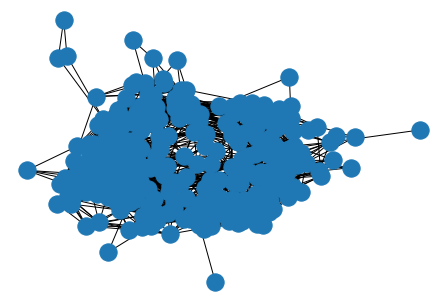

In [12]:
import networkx as nx
data_obj = None
for data in dataset_train:
    data_obj = data
    break
g = torch_geometric.utils.to_networkx(data_obj, to_undirected=True)
nx.draw(g)